In [2]:
import numpy as np
import pandas as pd
import optuna
from sklearn.preprocessing import MinMaxScaler

from utils import encode_features, get_train_test_data, train_model, evaluate_model, generate_individual, epsilon_rounding, get_relevant_candidates

optuna.logging.set_verbosity(optuna.logging.WARNING)

## Data

In [3]:
def load_data(data_filepath='Loan_data_train.csv'):
    """
    Input: path to .csv data file
    
    TODO: specify in feature_info whether features are of type:
        fixed, meaning cannot change for the counterfactual
        unique, meaning can only take existing categorical values
        increase, meaning their value can only increase and not decrease
        range, meaning their new value can take a range of values

    Returns:
        dataframe and feature configuration dictionary
    """
    df = pd.read_csv(data_filepath)
    df = df.drop('Loan_ID', axis=1)
    df = df.dropna()
    
    feature_config = {
        "categorical": ["Gender", "Married", "Education", "Self_Employed", "Property_Area", "Loan_Status"],
    
        "feature_info": [
            ('Gender', 'fixed'),
            ('Married', 'unique'),
            ('Dependents', 'fixed'),
            ('Education', 'increase'),
            ('Self_Employed', 'unique'),
            ('ApplicantIncome', 'range'),
            ('CoapplicantIncome', 'range'),
            ('LoanAmount', 'fixed'),
            ('Loan_Amount_Term', 'unique'),
            ('Credit_History', 'unique'),
            ('Property_Area', 'unique'),
        ],
    
        "categorical_features": ["Gender", "Married", "Education", "Self_Employed", "Property_Area"]
    }

    return df, feature_config

In [5]:
df, feat_conf = load_data()
df = encode_features(df, feat_conf["categorical"])

--- 
Encoded categorical features as follows:
Gender :  {'Female': 0, 'Male': 1}
Married :  {'No': 0, 'Yes': 1}
Education :  {'Not Graduate': 0, 'Graduate': 1}
Self_Employed :  {'No': 0, 'Yes': 1}
Property_Area :  {'Rural': 0, 'Semiurban': 1, 'Urban': 2}
Loan_Status :  {'N': 0, 'Y': 1}
---


## Model

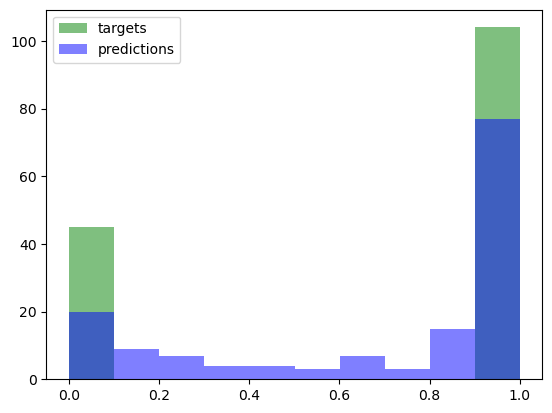

In [6]:
# Split and train a model
X_train, X_test, y_train, y_test = get_train_test_data(df)
model = train_model(X_train, y_train)
evaluate_model(model, X_test, y_test)

## TODO: Code for counterfactual search

In [7]:
def misfit(x_prime, y_target, model):
    """
    Optimisation criterion 1
    Calculate absolute difference between y_target and y_prime_prediction.
    """
    y_prime_prediction = model.predict_proba(x_prime)[0][0]
    return abs(y_target - y_prime_prediction)

In [8]:
def distance(X, x, x_prime, numerical, categorical):
    """
    Optimisation criterion 2
    Calculate distance between x_prime and x.
    """
    # Normalize data
    scaler = MinMaxScaler()
    scaler.fit(X[numerical])
    x_normalized = scaler.transform(x[numerical])
    x_prime_normalized = scaler.transform(x_prime[numerical])
        
    # Compute distances
    numeric_distance = np.linalg.norm(x_prime_normalized - x_normalized, axis=1)
    categorical_distance = (x_prime[categorical].values != x[categorical].values).sum(axis=1)
    
    return numeric_distance + categorical_distance

In [9]:
def sparsity(x, x_prime):
    """
    Optimisation criterion 3
    Return number of unchanged features.
    """
    return (x.values[0] == x_prime.values[0]).sum() / len(x.values[0])

In [10]:
def closest_real(X, x_prime, categorical, numerical):
    """
    Optimisation criterion 4
    Return the minimum distance between x_prime and any point in X.
    """
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X[numerical])
    x_prime_normalized = scaler.transform(x_prime[numerical])

    numeric_distance = np.linalg.norm(x_prime_normalized - X_normalized, axis=1)
    categorical_distance = (x_prime[categorical].values != X[categorical].values).sum(axis=1)
    
    # Compute total distance
    total_distance = numeric_distance + categorical_distance
    
    return min(total_distance)

In [11]:
def objective(trial, X, x, features, model, y_target, numerical, categorical):
    x_prime = x.copy()
    for feature in features:
        feature.sample(trial)
        x_prime[feature.name] = feature.value
    epsilon_rounding(x, x_prime, 1e-1)

    obj1 = misfit(x_prime, y_target, model)
    obj2 = distance(X, x, x_prime, numerical, categorical)
    obj3 = sparsity(x, x_prime)
    obj4 = closest_real(X, x_prime, categorical, numerical)

    return obj1, obj2, obj3, obj4

In [12]:
def get_counterfactuals(X, x, y_target, model, 
                        numerical, categorical, features, 
                        tol, optimization_steps, timeout):

    study = optuna.create_study(directions=['minimize', 'minimize', 'maximize', 'minimize'], 
                                sampler=optuna.samplers.NSGAIISampler(seed=42)) 
    
    study.optimize(lambda trial: objective(trial, X, x, features, model, 
                                           y_target, 
                                           numerical, 
                                           categorical), 
                   n_trials=optimization_steps, 
                   timeout=timeout)
    
    candidates_df = get_relevant_candidates(study, x, model, y_target, tol)
    
    return candidates_df

## Provided datapoint and data

In [14]:
X_obs, feat_conf = load_data("Loan_data_extracted.csv")
X_obs = encode_features(X_obs, feat_conf["categorical"])
X_obs

--- 
Encoded categorical features as follows:
Gender :  {'Female': 0, 'Male': 1}
Married :  {'No': 0, 'Yes': 1}
Education :  {'Not Graduate': 0, 'Graduate': 1}
Self_Employed :  {'No': 0, 'Yes': 1}
Property_Area :  {'Rural': 0, 'Semiurban': 1, 'Urban': 2}
Loan_Status :  {'N': 0, 'Y': 1}
---


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,1,0,3676,4301,172.0,360,1,0,1
1,0,1,1,1,0,12000,0,496.0,360,1,1,1
3,1,1,1,1,0,3400,2500,173.0,360,1,1,1
4,1,1,2,0,0,3987,1411,157.0,360,1,0,1
5,1,1,0,1,0,3232,1950,108.0,360,1,0,1
6,0,0,0,1,0,2900,0,71.0,360,1,0,1
7,1,1,3,1,0,4106,0,40.0,180,1,0,1
8,1,1,1,1,0,8072,240,253.0,360,1,2,1
9,1,1,2,1,0,7583,0,187.0,360,1,2,1
10,0,0,0,1,1,4583,0,133.0,360,0,1,0


In [15]:
customer = np.array([0,1,0,0,0,2000,1500,1000,480,0,1])
x = pd.DataFrame([customer], columns=X_obs.columns[:-1].tolist())

In [16]:
x

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,0,1,0,0,0,2000,1500,1000,480,0,1


In [17]:
# Check that our customer x did not get the loan
model.predict(x)
# and help her find out what she has to do in order to get the loan

array([0])

## Search for counterfactuals

In [19]:
# Make a list of Feature objects containing information about how 
# each feature is allowed to change when generating counterfactuals
change_features = generate_individual(X_obs, x, feat_conf["feature_info"])

In [20]:
# Set the desired new model prediction
y_CF = 0.7
print(f"Searching for counterfactuals with y_CF = {y_CF}...\n")
numerical_features = [x for x in df.columns if x not in feat_conf["categorical"]]
CFS = get_counterfactuals(X_obs, x, y_CF, model, 
                          numerical_features, 
                          feat_conf["categorical_features"], 
                          change_features, 
                          tol=0.05, 
                          optimization_steps=500, 
                          timeout=None) 

Searching for counterfactuals with y_CF = 0.7...



In [21]:
x

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,0,1,0,0,0,2000,1500,1000,480,0,1


In [22]:
CFS

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,0.0,1.0,0.0,0.0,0.0,3082.647900,1385.262491,1000.0,360.0,1.0,0.0
1,0.0,0.0,0.0,1.0,1.0,6386.560607,2444.295303,1000.0,360.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,3311.489898,113.404357,1000.0,360.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,3311.489898,113.404357,1000.0,360.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,10055.739631,2638.282385,1000.0,360.0,1.0,2.0
5,0.0,0.0,0.0,1.0,1.0,5035.242945,1882.131037,1000.0,360.0,0.0,1.0
